In [ ]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

import zipfile
import requests
import glob as glob
import imageio.v2 as imageio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models, optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras import regularizers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from dataclasses import dataclass
import keras_tuner as kt

<ipython-input-2-3763176bd3e9>:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Set a fixed seed value to ensure reproducibility
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Path to the main image dataset folder (organized by class subfolders)
data_path = "/content/drive/MyDrive/image-data/images"

# Initialize empty lists for storing images and their corresponding labels
images = []
labels = []

# Iterate over all subfolders (each representing a class)
for class_folder in os.listdir(data_path):
    class_path = os.path.join(data_path, class_folder)

    # Ensure that the path is indeed a folder
    if os.path.isdir(class_path):
        # Iterate over all image files in the class folder
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)

            # Skip files that are not image formats
            if not img_file.endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Read the image and resize it to the expected input shape (224x224)
            img = cv2.imread(img_path)

            # Skip if the image could not be loaded
            if img is None:
                print(f"Error reading image: {img_path}")
                continue

            img = cv2.resize(img, (224, 224))

            # Append the image and its corresponding class label to the lists
            images.append(img)
            labels.append(class_folder)

# Convert lists to NumPy arrays for model input
images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")


Anzahl der geladenen Bilder: 1280


In [ ]:
# Labeling
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(integer_labels)

random_indices = np.random.permutation(len(images))
images = images[random_indices]
categorical_labels = categorical_labels[random_indices]


In [ ]:
# Manually split the dataset into training, testing, and validation sets
train_images = images[:896]
train_labels = categorical_labels[:896]

test_images = images[896:1152]
test_labels = np.array(categorical_labels[896:1152])

valid_images = images[1152:]
valid_labels = categorical_labels[1152:]

# Create TensorFlow Datasets from the NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))

# Define a function to apply rescaling to each image-label pair
def apply_rescaling(image, label):
    image = layers.Rescaling(scale=1./255)(image)  # Normalize pixel values to [0, 1]
    return image, label

# Apply the rescaling to all datasets using the map function
train_dataset_rescaled = train_dataset.map(apply_rescaling)
test_dataset_rescaled = test_dataset.map(apply_rescaling)
valid_dataset_rescaled = valid_dataset.map(apply_rescaling)


In [ ]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(factor=(-0.3, 0.3)),
        layers.RandomZoom(0.25, 0.25),
        layers.RandomWidth(factor=(-0.2, 0.2)),
        layers.RandomBrightness(0.25),
        layers.RandomContrast(0.25),
        layers.RandomCrop(height=224, width=224),
        layers.RandomHeight(factor=(-0.15, 0.15)),
        layers.RandomTranslation(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15)),
    ]
)

def apply_augmentation(image, label):
    image = data_augmentation(image, training=True)
    image = tf.image.resize_with_crop_or_pad(image, target_height=224, target_width=224)
    return image, label

train_dataset_augmented = train_dataset.map(apply_augmentation)

In [ ]:
# Extract images and labels from the dataset
train_images_augmented, train_labels_augmented = zip(*train_dataset_augmented)

# Convert to Numpy-Arrays
train_images_augmented = np.array(train_images_augmented)
train_labels_augmented = np.array(train_labels_augmented)

In [ ]:
def build_model(hp):
    model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freezing VGG-19-layers
    for layer in model.layers[:-8]:
        layer.trainable = False

    # Add own layers for classification 
    x = model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=hp.Int('units', min_value=192, max_value=512, step=32), activation='relu')(x)
    x = layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    predictions = layers.Dense(8, activation='softmax')(x)

    # Hyperparameter Batch-Size
    hp_batch_size = hp.Int('batch_size', min_value=16, max_value=32, step=16)

    # Create model
    full_model = models.Model(inputs=model.input, outputs=predictions)

    # compile the model
    full_model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

    return full_model

In [ ]:
# Definition Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='VGG-19 Hyperparameter Tuning'
)

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_images_augmented, train_labels_augmented, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the optimal dropout rate is {best_hps.get('dropout')},
 and the optimal batch size is {best_hps.get('batch_size')}.
""")

Trial 30 Complete [00h 01m 08s]
val_accuracy: 0.7722222208976746

Best val_accuracy So Far: 0.7722222208976746
Total elapsed time: 00h 15m 22s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480, the optimal learning rate for the optimizer
is 1e-05, the optimal dropout rate is 0.2,
 and the optimal batch size is 16.



In [ ]:
# Batch sizes
train_dataset_augmented = train_dataset_augmented.batch(batch_size=16)
test_dataset = test_dataset.batch(batch_size=16)
valid_dataset = valid_dataset.batch(batch_size=16)

In [ ]:
# Optimal Hyperparameters
best_units = 480
best_learning_rate = 1e-05

# ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.h5',       
    save_best_only=True,   
    monitor='val_accuracy',   
    mode='max',           
    verbose=0              
)

# Load VGG-19 Convolutional Base with ImageNet-weights
input_shape = (224, 224, 3)
vgg19_conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Unlocking the last 8 layers
vgg19_conv_base.trainable = True
for layer in vgg19_conv_base.layers[:-8]:
    layer.trainable = False

# Create model
model = models.Sequential()
model.add(vgg19_conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(units=best_units, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='softmax'))


# Compile model with the best learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=best_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stop
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Model summary
model.summary()

# Training
history = model.fit(train_dataset_augmented,
                    epochs=55,  
                    batch_size=16,  
                    validation_data=valid_dataset,
                    callbacks=[early_stopping, model_checkpoint])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 480)               246240    
                                                                 
 dropout_4 (Dropout)         (None, 480)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 3848      
                                                                 
Total params: 20274472 (77.34 MB)
Trainable params: 14408936 (54.97 MB)
Non-trainable params: 5865536 (22.38 MB)
_______

In [ ]:
best_model = load_model('best_model.h5')
# Valididation
validation_results = model.evaluate(valid_dataset)
validation_accuracy = validation_results[1]
print(f'Validation Accuracy: {validation_accuracy*100:.3f}%')

test_results = model.evaluate(test_dataset)
test_accuracy = test_results[1]
print(f'Test Accuracy: {test_accuracy*100:.3f}%')

8/8 [==============================] - 1s 80ms/step - loss: 0.2163 - accuracy: 0.9375
Validation Accuracy: 93.750%
16/16 [==============================] - 1s 78ms/step - loss: 0.2161 - accuracy: 0.9531
Test Accuracy: 95.312%


16/16 [==============================] - 1s 78ms/step
Test Accuracy: 0.953125
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        37
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        31
           3       0.94      0.94      0.94        34
           4       1.00      1.00      1.00        35
           5       0.93      1.00      0.96        27
           6       0.89      0.85      0.87        39
           7       1.00      1.00      1.00        23

    accuracy                           0.95       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.95      0.95      0.95       256



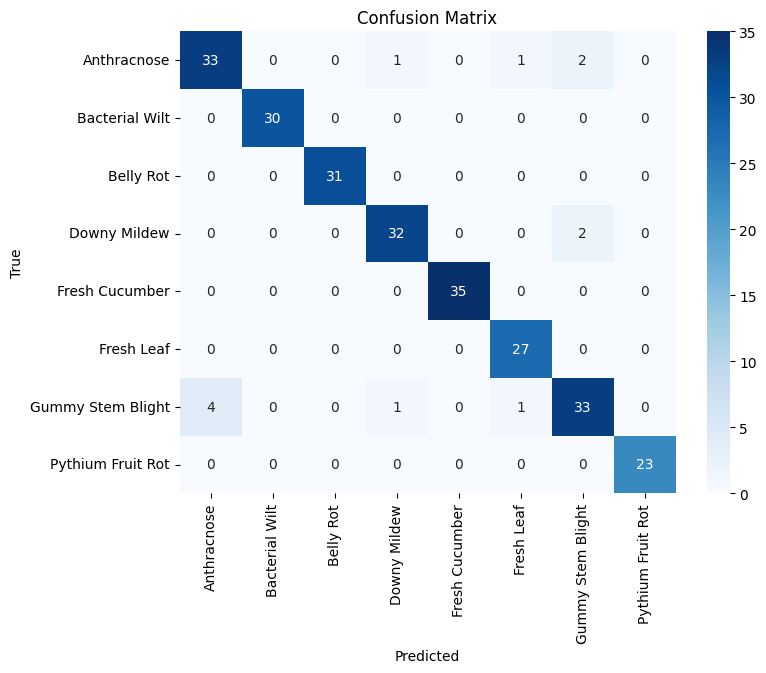

In [ ]:
# Generate predictions for the test dataset
test_predictions = model.predict(test_dataset)

# Get the predicted class labels (highest probability per sample)
predicted_labels = np.argmax(test_predictions, axis=1)

# Convert one-hot encoded true labels back to class indices
true_labels = np.argmax(test_labels, axis=1)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test Accuracy: {test_accuracy}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print a detailed classification report (precision, recall, f1-score)
class_report = classification_report(true_labels, predicted_labels)
print('Classification Report:\n', class_report)

# Define class names for visualization
class_names = [
    "Anthracnose", "Bacterial Wilt", "Belly Rot", "Downy Mildew",
    "Fresh Cucumber", "Fresh Leaf", "Gummy Stem Blight", "Pythium Fruit Rot"
]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



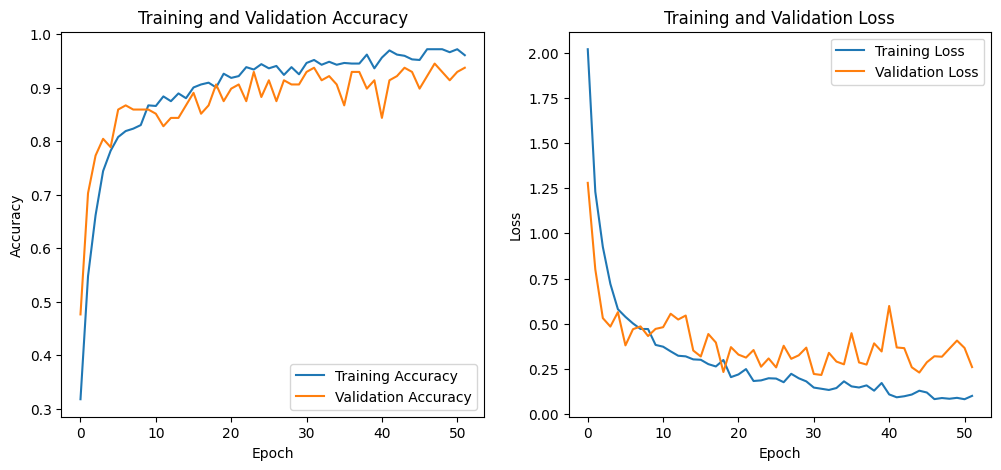

In [ ]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()